## i. Perkenalan

**Nama:** Ivan Carlos Tambunan

**Dataset:** Dataset terdiri dari informasi pengguna dalam mengajukan pinjaman(loan) termasuk data pribadi seperti umur, pendapatan, lama bekerja, jenis properti dan begitu juga dengan data informasi peminjaman seperti tujuan peminjaman, bunga, informasi sejarah default dan sejarah lama credit dari pengguna.

**Objektif:** Peminjaman yang default bisa mengakibatkan kerugian fiansial terhadap pihak bank. Jadi, pihak bank membutuhkan suatu cara untuk mengurangi risiko adanya default. Maka dari itu akan dibuatnya sebuah model yang dapat memprediksi peminjam yang memiliki risiko tinggi default sehingga membantu pihak bank memilih pemberian pinjaman yang tepat. Model yang akan dibuat terdiri dari `K-Nearest Nieghbors`, `Support Vector Machine`, `Decision Tree`, `Random Forest` dan `Ada Boost`. Kemudian akan dilakukan `Cross Validation` untuk kelima model untuk dipilih model terbaik. Kemudian model terbaik akan dievaluasi dengan metric `accuracy`, `recall` yang lalu akan ditune semaksimal mungkin untuk meningkatkan accuracy dan recall nya untuk memprediksi peminjam dengan risiko default. Metric `ROC AUC` untuk melihat apakah model dapat memisahkan tiap class secara baik.

## ii. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, recall_score, make_scorer, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## iii. Data Loading

In [2]:
# Load dataset ke dataframe
df = pd.read_csv('credit_risk_dataset.csv')

In [3]:
# Tampilan dataset dalam bentuk dataframe
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [4]:
# Cek summary dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


> Dari hasil summary, dataset memiliki `12` kolom dan `32581` baris. `3` kolom tipe float, `5` kolom tipe integer dan `4` kolom tipe object. Dataset memiliki beberapa missing value pada kolom `person_emp_length` dan `loan_int_rate`. Akan dilakukan handle missing value nanti saat preproccesing.

In [5]:
# Cek missing value dari dataset
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

> Kolom `person_emp_length` dan kolom `loan_int_rate` mempunyai nilai missing value sebesar `895` dan `3116`.

In [6]:
# Cek data duplikat dari dataset
df.duplicated().sum()

np.int64(165)

In [7]:
# Drop data duplikat karena redundan untuk modeling algoritma
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [8]:
# tampilkan summary descriptive data
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,1.000000,0.830000,30.000000


## iv. Exploratory Data Analysis (EDA)

#### 1. Distribusi Kolom Numerik

> Akan dicek distribusi dari tiap-tiap numerical fitur dari dataset ini. Umumnya dataset bank memiliki distribusi yang miring atau skewed. Dari hasil analisis ini akan dilihat apakah distribusi dari tiap fitur di dataset ini benar skewed.

In [9]:
# Kelompokkan kolom numeric dalam satu list
numerical_columns = ['person_age', 'person_income', 
                    'person_emp_length', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 
                    'cb_person_cred_hist_length']

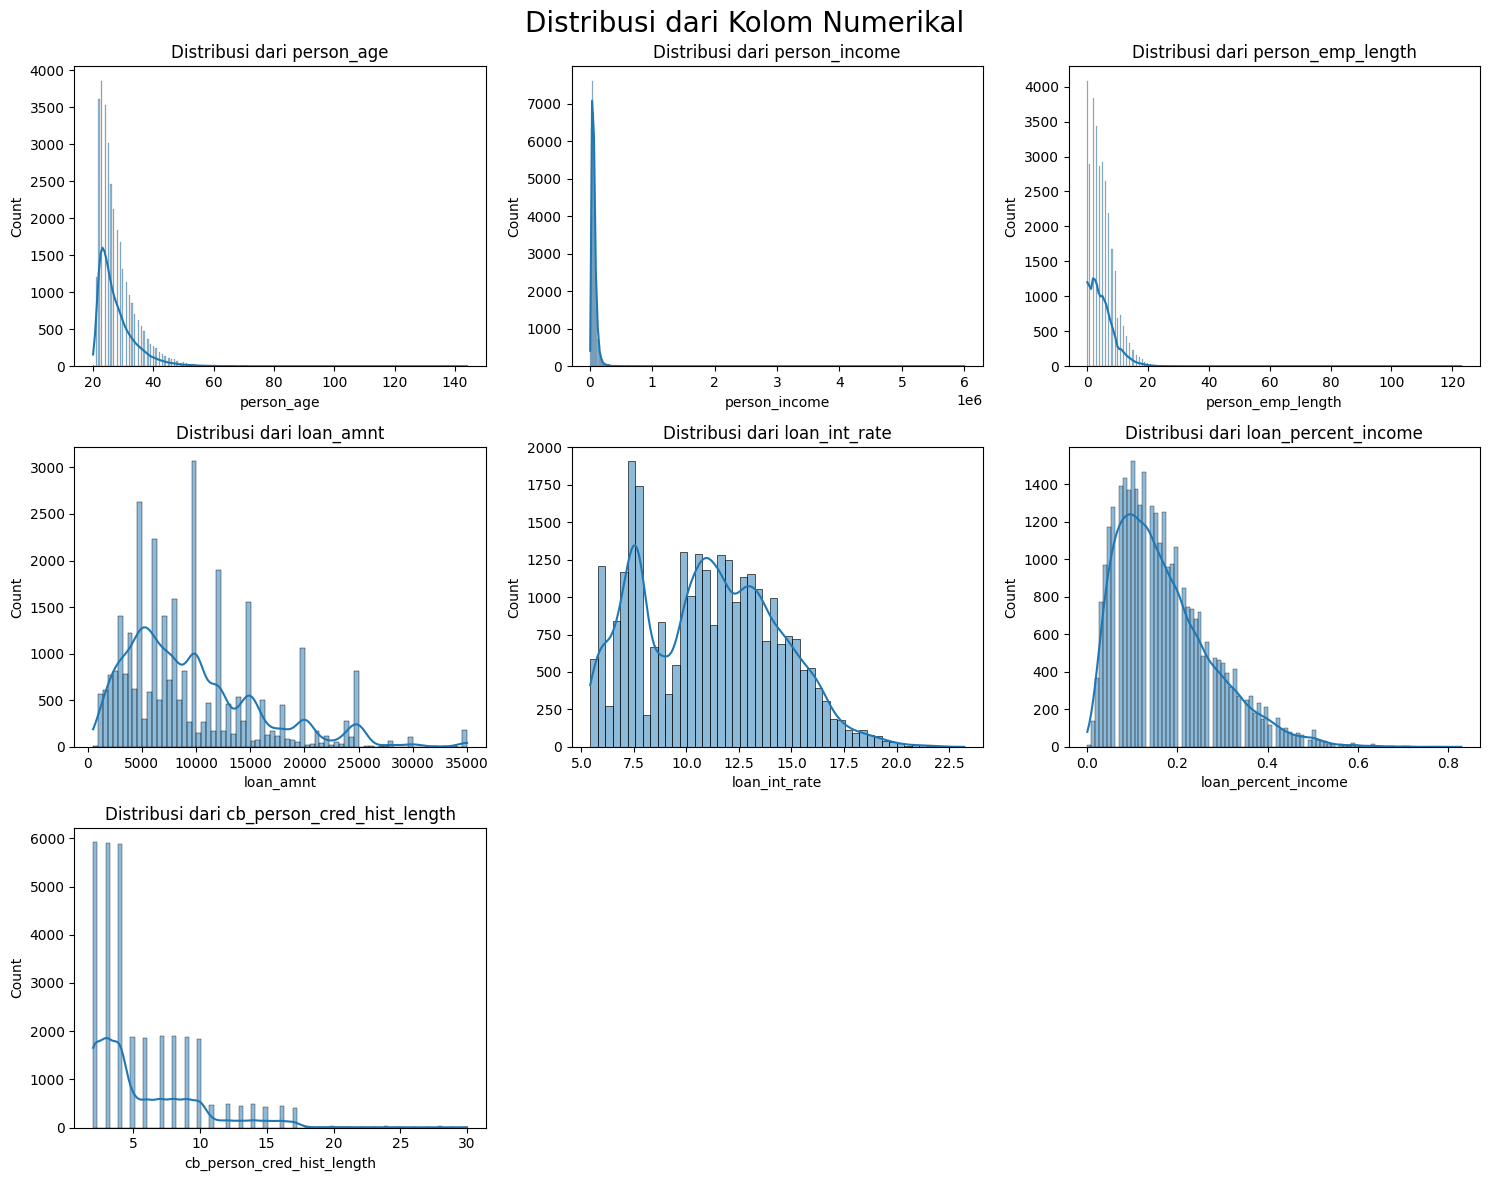

In [10]:
# Visualisasi distribusi tiap kolom numeric
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
plt.suptitle('Distribusi dari Kolom Numerikal', fontsize=20)
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], 
                kde=True, 
                ax=axes[i])
    axes[i].set_title(f"Distribusi dari {col}")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> Dari hasil visualisasi distribusi dari tiap-tiap kolom numerik, dapat dilihat bahwa seluruh kolom memiliki distribusi yang skewed, terutama kolom `person_income` yang extreme skewed. Ini wajar biasanya terjadi pada kolom `person_income` karena ada sebagian pengguna yang memiliki pendapatan yang tinggi, ini sebagai outlier nya. Kecuali untuk kolom `loan_int_rate` yang distribusinya kurang lebih normal.  

#### 2. Persentase Loan Status

In [11]:
# cek jumlah tiap value pada loan_status
df['loan_status'].value_counts()

loan_status
0    25327
1     7089
Name: count, dtype: int64

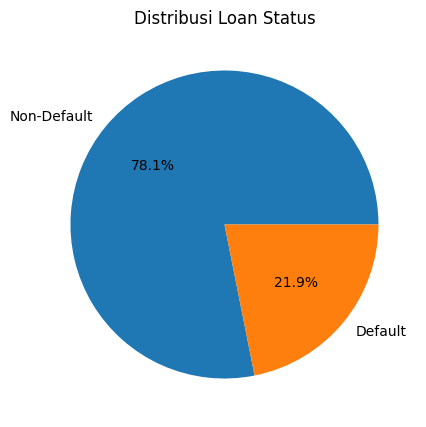

In [12]:
# Plot pie chart persentase loan_status
warna = sns.color_palette('tab10', 2)

plt.figure(figsize=(5, 5))
plt.pie(df['loan_status'].value_counts().sort_index(),
        labels = ['Non-Default', 'Default'], 
        colors=warna, 
        autopct='%1.1f%%')
plt.title('Distribusi Loan Status')
plt.show()

> Dari visualisasi diatas, perbandingan dari `loan_status` yaitu `default(1) = 21.9%` dan `non-default(0) = 78.1%`. Informasi ini juga berguna untuk menunjukkan seberapa balance data target dari `loan_status`, yang ternyata data target cukup `imbalance`. Dalam data preprocessing nanti bisa juga dilakukan `data balancing`. Karena nilai `default` yang cukup tinggi, perlu dibuatnya sebuah model untuk memprediksi `loan_status` dan mengurangi nilai `default` kedepannya.

### 3. Correlation Matrix Tiap Fitur

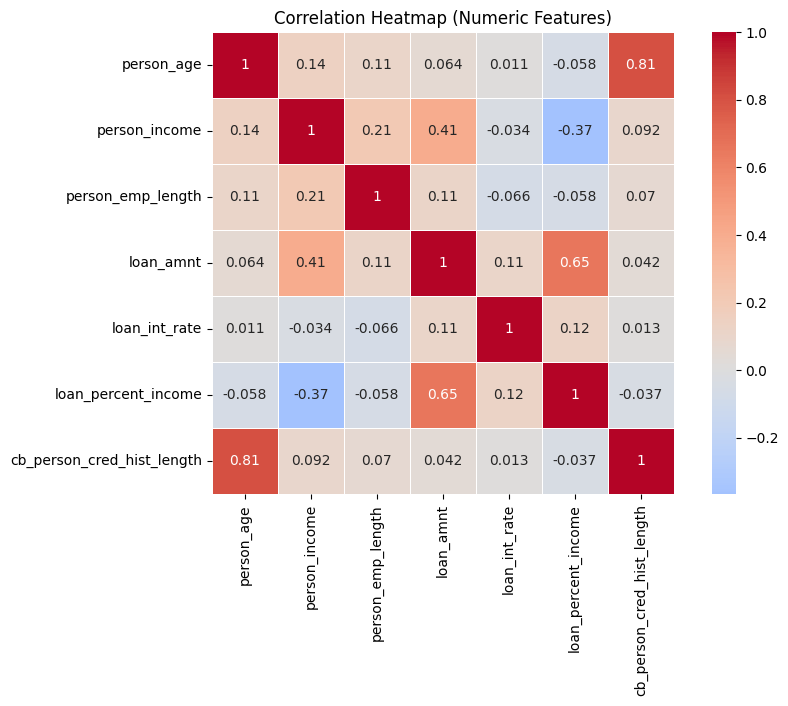

In [13]:
# visualisasi corr matrix tiap fitur numerik
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_columns].corr(method='spearman'),
             center=0, 
             annot=True, 
             cmap='coolwarm', 
             square=True, 
             linewidth=0.4)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

> Dari sebagian banyak fitur memiliki korelasi yang cukup lemah, namun ada beberapa yang memiliki korelasi positif yang moderate dan kuat. Semakin tinggi umur pengguna `person_age`, semakin tinggi pula tahun credit history pengguna tersebut `cb_person_cred_hist_length`. 

> Begitu juga, semakin tinggi jumlah pinjaman `loan_amount`, sebagian besar dari pengguna akan membayar cicilan yang lebih besar juga berdasarkan persentase income pengguna tersebut `loan_percent_income`. 

> Karena `loan_percent_income` didapat dari `loan_amnt / person_income`, `person_income` juga memiliki korelasi negatif dengan `loan_percent_income`. Jadi, semakin tinggi income pengguna `person_income`, semakin kecil `loan_percent_income`, karena income pengguna sebagai pembagi. 

> Semakin kecil `loan_percent_income`, semakin kecil juga risiko pegguna `default (1)` pada umumnya, meskipun banyak faktor yang mempengaruhi pengguna akan default atau tidak.

### 4. Pengaruh Loan Percent Income Terhadap Loan Status

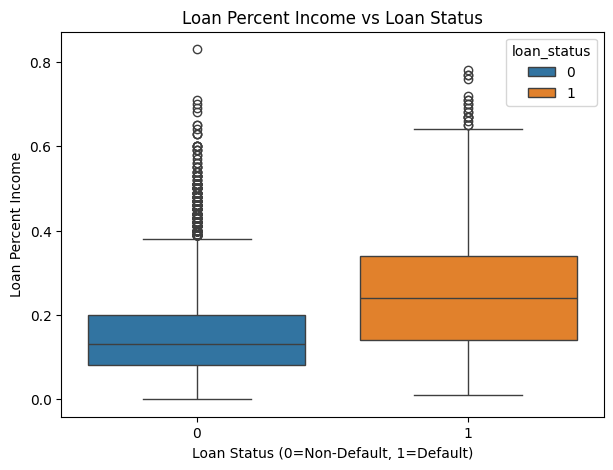

In [14]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df,
            x='loan_status', 
            y='loan_percent_income',
            hue='loan_status',
            palette='tab10')
plt.title("Loan Percent Income vs Loan Status")
plt.xlabel("Loan Status (0=Non-Default, 1=Default)")
plt.ylabel("Loan Percent Income")
plt.show()

> Dari visualisasi diatas dapat dilihat bahwa nilai `median` dari `loan_percent_income` yang relatif kecil akan cenderung lebih ke `Non-default (0)`, dan sebaliknya dengan `default (1)`. Tetapi `loan_percent_income` bukan semata-mata hanya faktor yang mempengaruhi `loan_status`, banyak juga faktor yang mempengaruhi pengguna default atau tidak, sehingga muncul beberapa outliers di boxplot tersebut dimana keadaan yang 'spesial' pengguna tetap `non-default` meskipun memiliki `loan_percent_income` (risk) yang tinggi.

### 5. Distribusi Kolom Kategorikal

In [15]:
# Masukkan kolom kategorikal dalam satu list
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

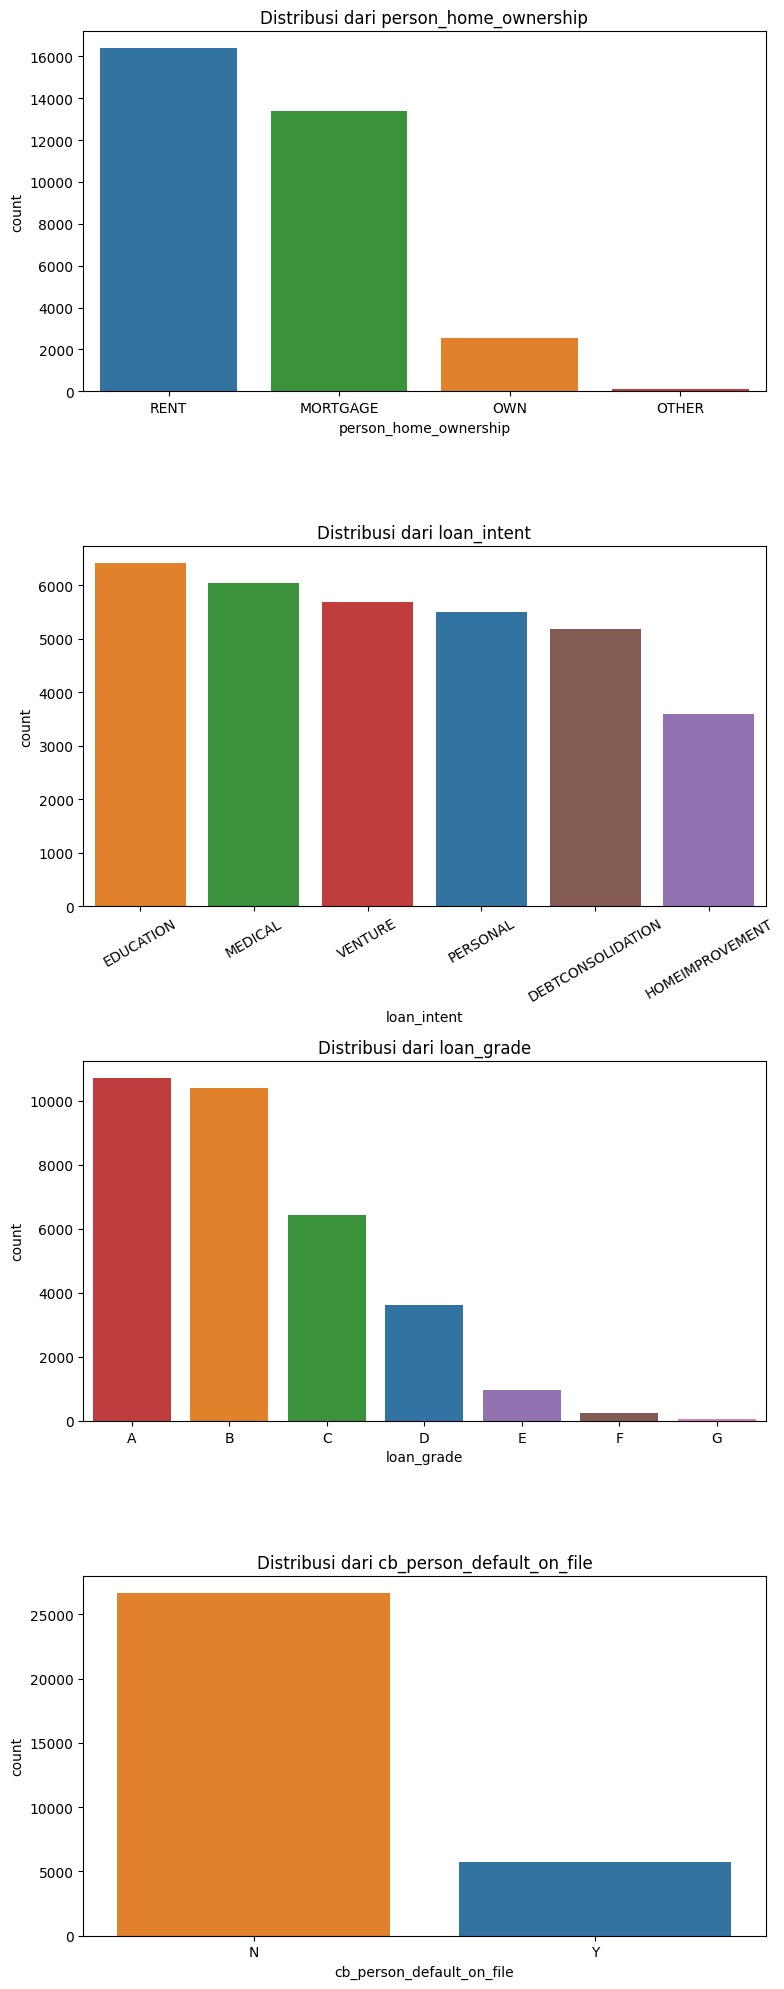

In [16]:
# Visualisasi distribusi tiap kolom kategorikal
rows = 4
cols = 1

fig, axes = plt.subplots(rows, cols, figsize=(8, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df,
                x=col,
                palette='tab10',
                hue=col, 
                order=df[col].value_counts().index, 
                ax=axes[i])
    axes[i].set_title(f"Distribusi dari {col}")
    if col == 'loan_intent':
        axes[i].tick_params(axis='x', rotation=30)
    else:
        continue

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> - Sebagian besar pengguna yang mengajukan loan adalah pengguna yang properti nya mengontrak (RENT) dan memiliki pinjaman KPR (MORTGAGE).
> - Distribusi kebutuhan (loan_intent) pengguna dalam mengajukan loan bermacam-macam, hampir merata dari keseluruhan kebutuhan.
> - Mayoritas `loan_grade` dari pengguna adalah grade `A` dan `B`, kemudian moderate untuk `C` dan `D`. Grade `A` memiliki risiko terendah (low risk) sampai grade `G` dengan risiko tinggi (high risk).
> - Mayoritas pengguna tidak memiliki `cb_person_default_on_file`. 

### 6. Pengaruh Loan Grade dan History Default terhadap Loan Status

#### a. Loan Grade v Loan Status

> Akan dianalisa, untuk menunjukkan risiko dari tiap `loan_grade` terhadap `loan_status`.

In [17]:
# Cari mean dari loan_status pada tiap loan_grade, mean menjadi persentase
default_rate = df.groupby('loan_grade')['loan_status'].mean().reset_index()
default_rate.rename(columns={'loan_status': 'default_rate'}, inplace=True)

# tampilkan persentase default rate tiap grade
default_rate

,loan_grade,default_rate
0,A,0.099598
1,B,0.163185
2,C,0.207518
3,D,0.590608
4,E,0.644860
5,F,0.705394
6,G,0.984375


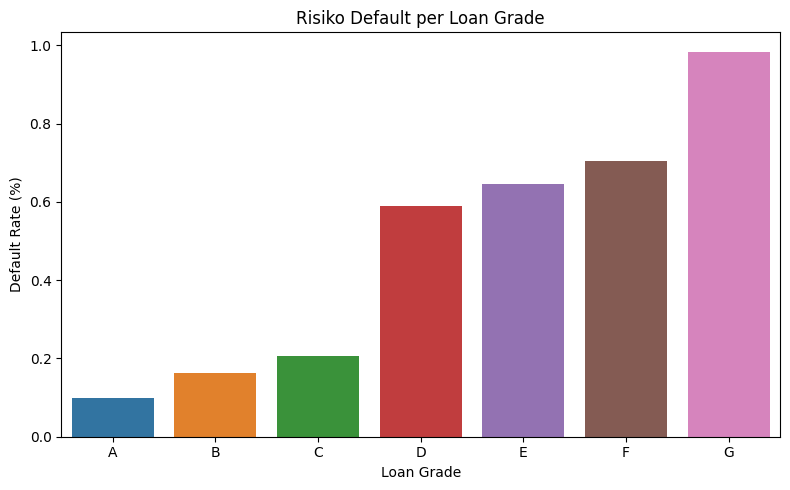

In [18]:
# Visualisasi default risk tiap grade
plt.figure(figsize=(8,5))
sns.barplot(
    data=default_rate,
    x='loan_grade',
    y='default_rate',
    hue='loan_grade',
    palette='tab10'
)

plt.title("Risiko Default per Loan Grade")
plt.ylabel("Default Rate (%)")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

> - Bisa dilihat dari hasil analisis dataset ini, grade `D` sampai `G` memiliki risiko yang tinggi terjadinya default `>60%`.
> - Sedangkan untuk grade `A` sampai `C` memiliki persentase default yang rendah `<20%`.
> - Visualisasi ini menunjukkan dan membuktikan risiko default rate dari tiap-tiap grade. Maka dari itu perlu nya diperhatikan untuk pengguna yang berada pada grade dari `D` sampai `G`. 

#### b. History Default v Loan Status

> Analisa ini akan menunjukkan korelasi apakah pengguna yang punya `cb_person_default_on_file` akan default lagi atau tidak.

In [19]:
# Cari mean dari loan_status berdasarkan ya atau tidak dari history default, mean menjadi persentase
default_rate_cb = df.groupby('cb_person_default_on_file')['loan_status'].mean().reset_index()
default_rate_cb.rename(columns={'loan_status': 'default_rate'}, inplace=True)

# tampilkan persentase 
default_rate_cb

,cb_person_default_on_file,default_rate
0,N,0.184329
1,Y,0.378709


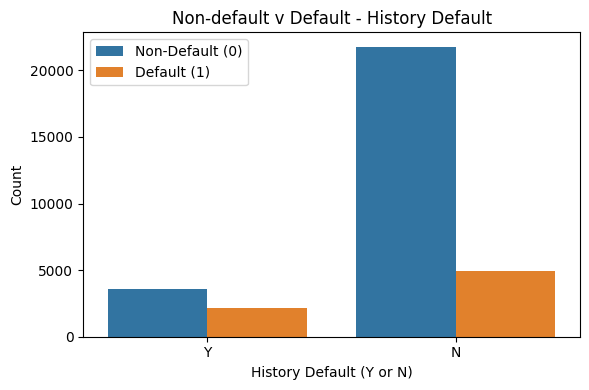

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='cb_person_default_on_file',
    hue='loan_status'
)
plt.title("Non-default v Default - History Default")
plt.xlabel("History Default (Y or N)")
plt.ylabel("Count")
plt.legend(["Non-Default (0)", "Default (1)"])
plt.tight_layout()
plt.show()

> Persentase yang cukup kecil, meskipun pengguna memiliki history default, kemungkinan nya **kecil** untuk default lagi. Berarti ada faktor lain yang bisa mempengaruhi seorang pengguna untuk default lagi atau tidak.

## v. Feature Engineering

### 1. Feature dan Target Split

> Split fitur dan target. Kolom `loan_status` menjadi target, karena kolom ini yang akan menjadi target prediksi dari model yang akan dibuat.

In [21]:
# split X fitur dan y target
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

In [22]:
# tampilan dataset X
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4


In [23]:
# tampilan dataset y
y

0        1
1        0
2        1
3        1
4        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: loan_status, Length: 32416, dtype: int64

### 2. Split Kolom Berdasarkan Tipe

> Perlu dilakukan split kolom berdasarkan tipe kolomnya, numerik, kategorikal nominal, kategorikal ordinal dan kolom binary. Split ini akan mempermudah nanti untuk melakukan scaler dan encode di pipeline, karena di dalam pipeline, saat scaling dan encoding memerlukan data per tipe kolom nya dalam sebuah list.

In [24]:
# Split kolom ke dalam list berdasarkan tipe kolom
numerical_columns = ['person_age', 'person_income', 
                    'person_emp_length', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 
                    'cb_person_cred_hist_length']
categorical_nominal_columns = ['person_home_ownership', 'loan_intent']
categorical_ordinal_columns = ['loan_grade']
categorical_binary_columns = ['cb_person_default_on_file']

### 3. Cek Cardinality

> Perlu dilakukannya cek cardinality, karena untuk kolom tipe kategorikal memiliki cardinality yang tinggi sangat mempengaruhi kinerja model dalam memprediksi. Jika ada kolom yang memiliki cardinality yang tinggi, akan dilakukan cardinality handling.

In [25]:
# Cek cardinality pada fitur categorical nominal
X[categorical_nominal_columns].nunique()

person_home_ownership    4
loan_intent              6
dtype: int64

In [26]:
# Cek cardinality pada fitur categorical ordinal
X[categorical_ordinal_columns].nunique()

loan_grade    7
dtype: int64

> Karena value pada tiap kolom kategori tidak melebihi dari `10`, maka tidak perlu dilakukannya cardinality handling.

### 4. Train dan Test Split

> Lakukan Train dan Test split, untuk model ini akan dibuat `25%` data test, dan `75%` data train nya.

In [27]:
# terapkan train test split untuk split data, 30% data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=67)

# tampilkan shape data X
print(X_train.shape)
print(X_test.shape)

(24312, 11)
(8104, 11)


### 5. Handle Missing Value

> Ditemukan beberapa missing value sebelumnya pada data fitur `person_emp_length` dan `loan_int_rate`. Tidak ada missing value pada target `loan_status`.

In [28]:
# Cek missing value pada X train
X_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              658
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2331
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [29]:
# Cek missing value pada X test
X_test.isnull().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             229
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 764
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

> `person_emp_length`: Kolom ini merujuk pada berapa lama pengguna sudah bekerja. Missing value bisa terjadi jika pengguna:
> - Pengguna tidak pernah memberikan report sudah berapa lama pengguna bekerja
> - Pengguna merupakan seorang penganggur atau pensiun
> - Pengguna merupakan seorang pelajar<br>
> Jadi kemungkinan missing value ini tipe `Missing Non At Random (MNAR)` dalam situasi tersebut.

> `loan_int_rate`: Kolom merujuk pada bunga pinjaman yang ditagih bank kepada pengguna. Persentase bunga biasanya dipengaruhi oleh jumlah pinjaman, credit score, lama bekerja, dan lain-lain. Jadi bisa `Missing Non At Random (MNAR)` di situasi tersebut bila pinjaman tidak diterima atau pengguna tidak memenuhi kriteria.

> Karena dalam situasi sekarang, saya tidak mempunyai resource untuk menyelidiki data `MNAR`, untuk kali ini saya akan coba lakukan imputasi saja.
> Untuk handle missing value, akan dilakukan metode imputasi menggunakan `SimpleImputer`. Karena fitur yang memiliki missing value adalah fitur numerical, maka akan diimputasi berdasarkan distribusi atau nilai skew nya.

In [30]:
# Masukkan fitur missing value pada sebuah list
missing_value = ['person_emp_length', 'loan_int_rate']

In [31]:
# tampilkan nilai skew dari tiap kolom
for col in missing_value:
    print(f'{col} skewness: {df[col].skew()}')

person_emp_length skewness: 2.619915431174931
loan_int_rate skewness: 0.20700165410053864


> Untuk kolom `person_emp_length` memiliki distribusi yang skewed `>0.5`, maka akan diimputasi dengan nilai `median` dari kolom tersebut dan untuk kolom `loan_int_rate` memiliki distribusi yang normal `<0.5`, maka akan diimputasi dengan nilai `mean` dari kolom tersebut.

In [32]:
# gunakan SimpleImputer untuk imputasi mean dan median
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')

In [33]:
# imputasi kolom person_empg_length = median terhadap data train dan test
X_train[['person_emp_length']] = median_imputer.fit_transform(X_train[['person_emp_length']])
X_test[['person_emp_length']] = median_imputer.fit_transform(X_test[['person_emp_length']])

In [34]:
# imputasi kolom loan_int_rate = mean ke train dan test
X_train[['loan_int_rate']] = mean_imputer.fit_transform(X_train[['loan_int_rate']])
X_test[['loan_int_rate']] = mean_imputer.fit_transform(X_test[['loan_int_rate']])

In [35]:
# cek missing value setelah imputasi
X_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [36]:
X_test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

> Sudah berhasil diimputasi, tidak ada missing value lagi.

### 6. Handle Outlier

> Akan dilakukan deteksi dan handle outlier terhadap kolom-kolom `numerical` dari dataset.

In [37]:
# Buat fungsi cek skewness dengan hasil berupa dictionary
def check_skew(data, *column):
    """
        Fungsi ini untuk mengambil nilai skew dari beberapa kolom
    Args:
        data (dataframe): Table dataframe yang akan cek skew dari kolomnya

    Returns:
        dict: Menghasilkan sebuah dictionary berisi nama kolom: nilai skewnya
    """
    return {col: data[col].skew() for col in column if col in data.columns}

In [38]:
# panggil fungsi dan tampilkan hasil skew tiap kolom
skew_result = check_skew(X_train, 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length')

for col, skew in skew_result.items():
    print(f'{col} skew: {skew}')

person_age skew: 2.5394489355956855
person_income skew: 35.605394108493954
person_emp_length skew: 3.0406669012308924
loan_amnt skew: 1.194231062372562
loan_int_rate skew: 0.21451151039843278
loan_percent_income skew: 1.0666244872804904
cb_person_cred_hist_length skew: 1.6533813296509507


> Dari hasil skew dari tiap-tiap kolom diatas, ditemukan beragam distribusi dari hasil skew nya. Selanjutnya akan dilakukan pengolompokan tiap-tiap kolom berdasarkan distribusi atau nilai skewnya. Kemudian akan dihandle tiap-tiap kelompok berdasarkan distribusinya juga.

In [39]:
# Buat list kosong berdasarkan tiap distribusinya
normal_col = []
skewed_col = []
extreme_col = []

# Lakukan loop untuk memasukkan tiap kolom ke sebuah list sesuai distribusinya
for col, skewness in skew_result.items():
    if abs(skewness) > 1.0:
        extreme_col.append(col)
    elif abs(skewness) > 0.5:
        skewed_col.append(col)
    else:
        normal_col.append(col)

# tampilkan list yang sudah terisi
print(f'Normal: {normal_col}\nSkewed: {skewed_col}\nEkstreme Skewed: {extreme_col}')

Normal: ['loan_int_rate']
Skewed: []
Ekstreme Skewed: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length']


> Kemudian akan dicek persentase dari outlier pada tiap kolom. Akan dibuat fungsi untuk cek persentase outlier berdasarkan dari distribus atau nilai skew. Kemudian fungsi bisa dipanggil lagi untuk cek persentase outlier setelah handling berikutnya. Untuk handling outlier ini, akan dilakukan metode `Winsorizer Capping` untuk meng-cap outlier tanpa membuang data. Untuk khasus ini akan menghindari untuk drop data, agar lebih banyak data untuk dilakukan pembuatan model.

In [40]:
# Buat fungsi untuk cek persentase outlier di normal distribusi
def outlier_percentage_normal(data, column):
    """
        Fungsi ini untuk mem-print persentase jumlah skew dari kolom tersebut
    Args:
        data (dataframe): Dataframe yang kolomnya akan di cek nilai skew
        column (pandas.Series): Kolom yang akan dicek nilai skewnya
    """
    for col in column:
        std = data[col].std()
        lower_bound = data[col].quantile(0.25) - (std * 3)
        upper_bound = data[col].quantile(0.75) + (std * 3)

        outlier = data[(data[col] < lower_bound ) | (data[col] > upper_bound)]
        outlier_percentage = len(outlier) / len(data) * 100

        print(f'Persentase outlier kolom {col}: {outlier_percentage:.2f}%')

In [41]:
# Buat fungsi untuk cek persentase outlier di skewed distribusi
def outlier_percentage_skewed(data, column, distance):
    """
        Fungsi ini untuk mem-print persentase jumlah skew dari kolom tersebut
    Args:
        data (dataframe): Dataframe yang kolomnya akan di cek nilai skew
        column (pandas.Series): Kolom yang akan dicek nilai skewnya
        distance (int): nilai yang dikalikan IQR untuk mencari upper dan lower bound, 1.5 untuk moderate skew, 3 untuk extremely skewed
    """
    for col in column:
        iqr = data[col].quantile(0.75) - data[col].quantile(0.25)
        lower_bound = data[col].quantile(0.25) - ( iqr * distance )
        upper_bound = data[col].quantile(0.75) + ( iqr * distance )

        outlier = data[(data[col] < lower_bound ) | (data[col] > upper_bound)]
        outlier_percentage = len(outlier) / len(data) * 100

        print(f'Persentase outlier kolom {col}: {outlier_percentage:.2f}%')

In [42]:
# Cek persentase pada distribusi normal dan extremely skewed saja
outlier_percentage_normal(X_train, normal_col)
outlier_percentage_skewed(X_train, extreme_col, 3)

Persentase outlier kolom loan_int_rate: 0.00%
Persentase outlier kolom person_age: 0.76%
Persentase outlier kolom person_income: 1.33%
Persentase outlier kolom person_emp_length: 0.16%
Persentase outlier kolom loan_amnt: 0.58%
Persentase outlier kolom loan_percent_income: 0.07%
Persentase outlier kolom cb_person_cred_hist_length: 0.44%


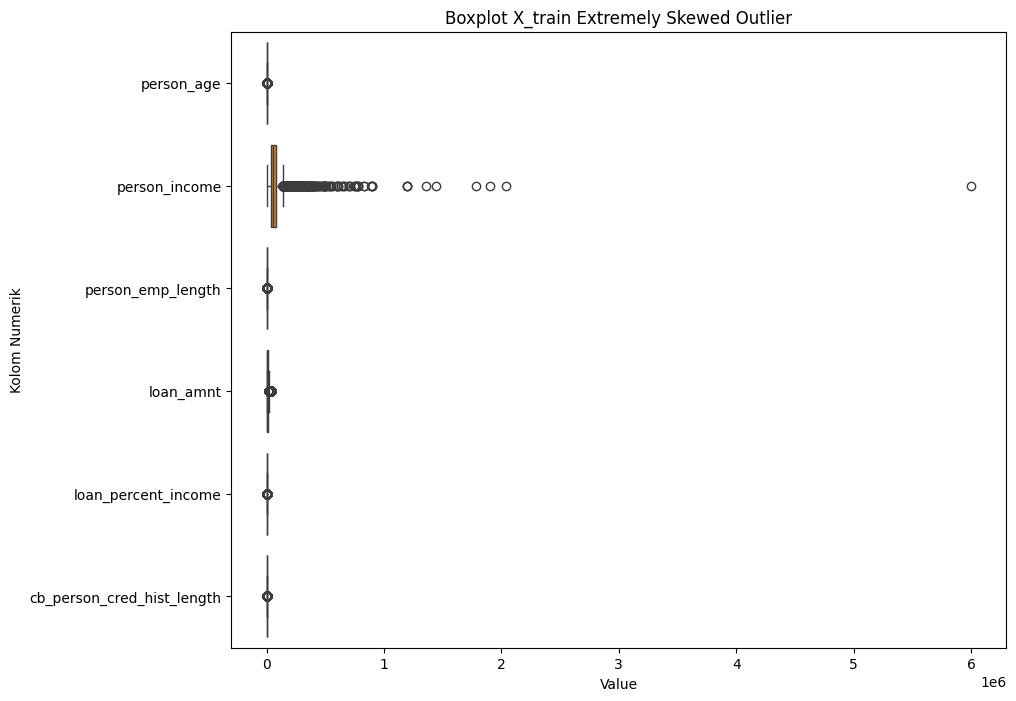

In [43]:
# Boxplot untuk extreme skew
plt.figure(figsize=(10, 8))
sns.boxplot(data=X_train[extreme_col], orient='h')

plt.title('Boxplot X_train Extremely Skewed Outlier')
plt.xlabel('Value')
plt.ylabel('Kolom Numerik')
plt.show()

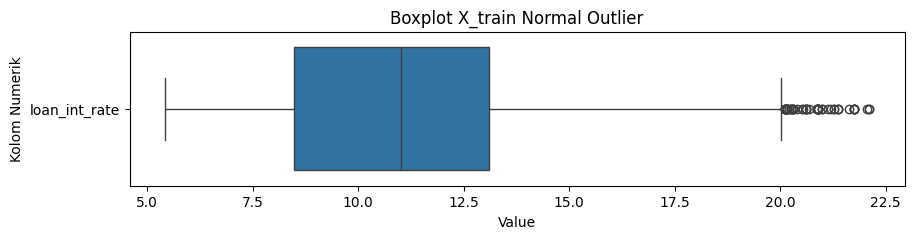

In [44]:
# Boxplot untuk distribusi normal
plt.figure(figsize=(10, 2))
sns.boxplot(data=X_train[normal_col], orient='h')

plt.title('Boxplot X_train Normal Outlier')
plt.xlabel('Value')
plt.ylabel('Kolom Numerik')
plt.show()

> - Untuk parameter Winsorizer, untuk distribusi normal akan digunakan `capping_method='gaussian'` karena jika distribusi normal, mendeteksi outlier dapat menggunakan nilai `mean` dan `standard deviation`, seperti melakukan `Z-Score`.
> - Untuk distribusi yang skewed, maka digunakan `capping_method='iqr'` menggunakan nilai seperti `kaurtil 1 (Q1)`, `kuartil 3 (Q3)` dan `IQR`, seperti melakukan `Tukey's Rule`.

In [45]:
# Buat fungsi untuk menerapkan Winsor Capping untuk normal outlier
def winsorizer_normal(data, variables, capping_method='gaussian', tail='both', fold=3):
    """
        fungsi ini untuk menerapkan winsorizer capping ke kolom yang mempunyai outlier, khusus kolom normal distribution
    Args:
        data (dataframe): Dataframe yang kolomnya akan diterapkan metode capping
        variables (list): List berisi kolom-kolom yang akan dicapping
        capping_method (str, optional): Metode outlier detection. Defaults to 'gaussian'.
        tail (str, optional): Sisi bagian yang akan dilihat outliernya. Defaults to 'both'.
        fold (int, optional): Nilai yang dipakai untuk mengalikan std(standard deviation). Defaults to 3.

    Returns:
        dataframe: dataframe yang kolomnya sudah tercapped
    """
    winsor = Winsorizer(capping_method=capping_method, tail=tail, fold=fold, variables=variables)
    data_capped = winsor.fit_transform(data)
    return data_capped

# Buat fungsi untuk menerapkan winsor capping untuk skew outlier
def winsorizer_skewed(data, variables, capping_method='iqr', tail='both', fold=3):
    """
        fungsi ini untuk menerapkan winsorizer capping ke kolom yang mempunyai outlier, khusus kolom skewed
    Args:
        data (dataframe): Dataframe yang kolomnya akan diterapkan metode capping
        variables (list): List berisi kolom-kolom yang akan dicapping
        capping_method (str, optional): Metode outlier detection. Defaults to 'iqr'.
        tail (str, optional): Sisi bagian yang akan dilihat outliernya. Defaults to 'both'.
        fold (int, optional): Nilai yang dipakai untuk mengalikan iqr. Defaults to 3.

    Returns:
        dataframe: dataframe yang kolomnya sudah tercapped
    """
    winsor = Winsorizer(capping_method=capping_method, tail=tail, fold=fold, variables=variables)
    data_capped = winsor.fit_transform(data)
    return data_capped

In [46]:
# Terapkan fungsi Winsor Capping untuk handle outlier
X_train = winsorizer_normal(X_train, normal_col)
X_train = winsorizer_skewed(X_train, extreme_col, fold=3)

In [47]:
# Cek persentase outlier setelah handling
outlier_percentage_normal(X_train, normal_col)
outlier_percentage_skewed(X_train, extreme_col, 3)

Persentase outlier kolom loan_int_rate: 0.00%
Persentase outlier kolom person_age: 0.00%
Persentase outlier kolom person_income: 0.00%
Persentase outlier kolom person_emp_length: 0.00%
Persentase outlier kolom loan_amnt: 0.00%
Persentase outlier kolom loan_percent_income: 0.00%
Persentase outlier kolom cb_person_cred_hist_length: 0.00%


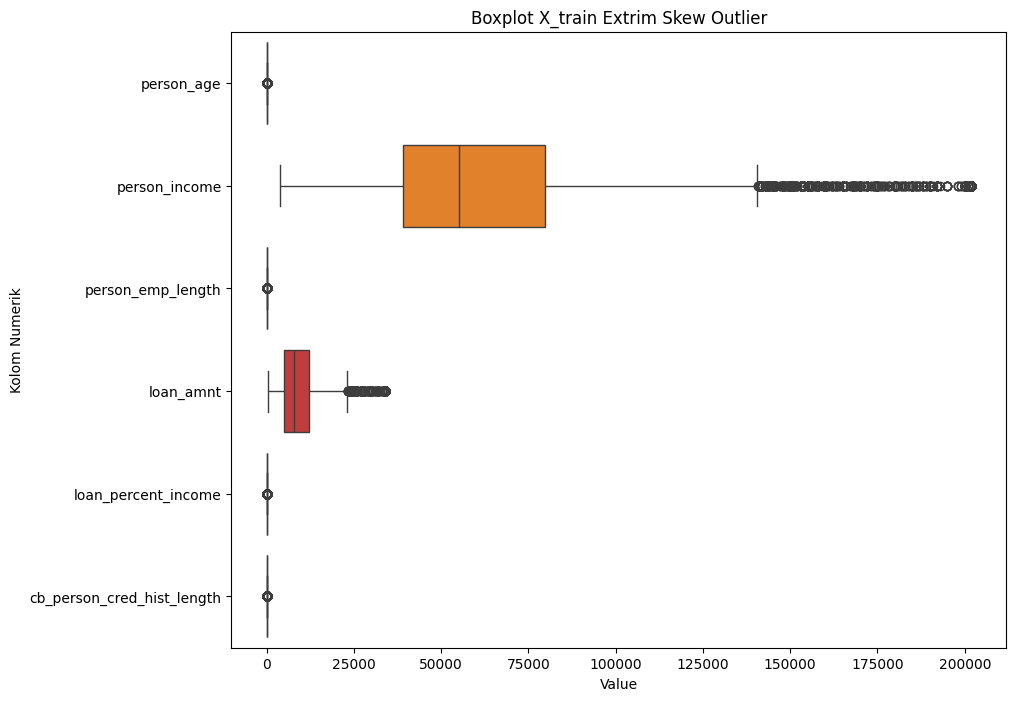

In [48]:
# Boxplot untuk extreme skew
plt.figure(figsize=(10, 8))
sns.boxplot(data=X_train[extreme_col], orient='h')

plt.title('Boxplot X_train Extrim Skew Outlier')
plt.xlabel('Value')
plt.ylabel('Kolom Numerik')
plt.show()

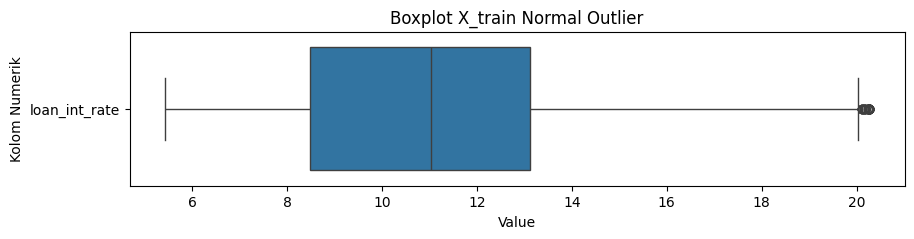

In [49]:
# Boxplot untuk distribusi normal
plt.figure(figsize=(10, 2))
sns.boxplot(data=X_train[normal_col], orient='h')

plt.title('Boxplot X_train Normal Outlier')
plt.xlabel('Value')
plt.ylabel('Kolom Numerik')
plt.show()

> Dari hasil persentase setelah capping method, sudah berhasil melakukan handling outlier.

## vi. Model Definition

> Akan dibuat 5 model algoritma, kemudian dari 5 model tersebut akan dipilih model yang terbaik untuk digunakan sebagai model prediksi nantinya. Model yang akan dibuat adalah `K-Nearest Neighbors', 'Support Vector Machine`, `Decision Tree`, `Random Forest` dan `AdaBoost`. Model kemudian akan dibuat dalam bentuk `pipeline` untuk mudah digunakan. Jadi proses scaling, encoding dan mapping kolom binary akan dimasukkan dalam `pipeline`.

> Model Scaler yang akan digunakan adalah `StandardScaler`, karena scaler ini sangat baik dan robust ke outlier untuk model algoritma seperti model yang akan dibuat di projek ini yaitu `K-Nearest Neighbors` dan `Support Vector Machine`, karena kedua model ini mengasumsi fitur memiliki distribusi normal dan mempunyai distance-based, seperti nilai `k` di `KNN` dan `margin` pada `SVM`.

> Model encoder yang akan digunakan untuk mengencode fitur categorical ordinal adalah `OrdinalEncoder`, karena memiliki value berupa tingkatan.

> Model encoder yang akan digunakan untuk mengencode fitur categorical nominal adalah `OneHotEncoder` dan dataset tidak memiliki high cardinality.

> Untuk kolom `cb_person_default_on_file` yang memiliki value `Y` dan `N` akan di-encode menjadi `Y:1` dan `N:0`. Dengan class `FunctionTransformer` di dalam pipeline, akan secara otomatis meng-encode kolom `cb_person_default_on_file` jika dilakukannya `model inference`.

> Metric evaluasi yang akan digunakan adalah `Recall Score` untuk mengurangi nilai `False Negative (FN)` sekecil mungkin agar model bisa memprediksi pengguna yang akan default, `Accuracy Score` sebagai metric seberapa akurat model dalam memprediksi, semakin tinggi score nya, semakin baik model memprediksi. Metric `PR-AUC` yang menunjukkan kurva `Precision` dan `Recall`, dari hasil ini akan terlihat perbandingannya, metric ini juga cocok untuk data yang imbalance. 

> Semua model akan dilakukan `Cross Validation` untuk memilih model yang terbaik dalam mempelajari suatu data. Model yang terbaik kemudian dievaluasi dengan default parameter dan setelah hyperparameter tuning dan kemudian dibandingkan. Metode hyperparameter yang akan digunakan adalah `RandomSearchCV`, agar lebih ringan dalam pengerjaannya.

In [50]:
# encode map kolom binary menjadi 0 dan 1
def binary_mapping(X):
    """
        Fungsi ini berguna untuk map kolom binary 'cb_person_default_on_file', yang value nya string menjadi 1 dan 0
    Args:
        X (dataframe): dataframe yang value dari kolom 'cb_person_default_on_file' nya akan diencode menjadi 1 dan 0

    Returns:
        dataframe: dataframe yang value kolom 'cb_person_default_on_file' sudah terencode menjadi 1 dan 0
    """
    X = X.copy()
    X['cb_person_default_on_file'] = X['cb_person_default_on_file'].map({'Y': 1, 'N': 0}).fillna(0)
    return X

binary_transformer = FunctionTransformer(binary_mapping, validate=False)

In [51]:
# buat preprocessor yang akan dimasukkan kedalam pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numerical_columns),
        ('categorical_nominal', OneHotEncoder(drop='first', 
                                              sparse_output=False, 
                                              handle_unknown='ignore'), categorical_nominal_columns),
        ('categorical_ordinal', OrdinalEncoder(categories=[['A','B','C','D','E','F','G']], 
                                               handle_unknown='use_encoded_value', 
                                               unknown_value=-1), categorical_ordinal_columns),
        ('binary', 'passthrough', ['cb_person_default_on_file'])
    ],
    remainder='drop'
)

#### 1. K-Nearest Neighbors (KNN)

In [52]:
# pipeline model KNN
knn = Pipeline([
    ('binary_map', binary_transformer),
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

#### 2. Support Vector Machine (SVM)

In [53]:
# pipeline model SVM
svc = Pipeline([
    ('binary_map', binary_transformer),
    ('preprocessor', preprocessor),
    ('svc', SVC(random_state=67))
]) 

#### 3. Decision Tree

In [54]:
# pipeline model Decision Tree
dtc = Pipeline([
    ('binary_map', binary_transformer),
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=67))
])

#### 4. Random Forest

In [55]:
rfc = Pipeline([
    ('binary_map', binary_transformer),
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(random_state=67))
]) 

#### 5. AdaBoost

In [56]:
ada = Pipeline([
    ('binary_map', binary_transformer),
    ('preprocessor', preprocessor),
    ('ada', AdaBoostClassifier(random_state=67))
])

## vii. Model Training

#### 1. Cross Validation

> Metode `Cross Validation` akan dilakukan untuk mengevaluasi seberapa baik tiap-tiap model yang akan digunakan dalam mempelajari sebuah data, kemudian diambil model terbaik untuk dilakukan training dan evaluasi.. Metode ini akan melakukan training beberapa kali tergantung dengan nilai `folds` nya dan kemudian diambil rata-rata performa nya dari beberapa training tersebut. Untuk model training ini, akan dilakukan dengan nilai `folds = 5`, yang berarti model akan melakukan `training 4 kali, test 1 kali`.

In [57]:
# split dataset dalam k folds - 5 folds
skfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=67)

In [58]:
# lakukan cross validation dari kelima model
models = {
    "KNN": knn,
    "SVC": svc,
    "Decision Tree": dtc,
    "Random Forest": rfc,
    "AdaBoost": ada
}

results = []

for name, model in models.items():
    cv = cross_val_score(model, X_train, y_train, cv=skfold, 
                         scoring='recall', n_jobs=-1)
    
    results.append({
        "Model": name,
        "Mean Recall": cv.mean(),
        "Std": cv.std(),
        "Min Recall": cv.min(),
        "Max Recall": cv.max()
    })

df_results = pd.DataFrame(results)
df_results

,Model,Mean Recall,Std,Min Recall,Max Recall
0,KNN,0.606704,0.002948,0.603220,0.610795
1,SVC,0.636432,0.010322,0.628788,0.656250
2,Decision Tree,0.759893,0.010359,0.740530,0.769886
3,Random Forest,0.716340,0.010622,0.698864,0.726585
4,AdaBoost,0.637194,0.016181,0.614002,0.662879


> Dari nilai `Cross Validation Mean Recall` yang terbaik adalah model `DecisionTree`, maka akan digunakan model `DecisionTree` untuk dilakukannya model training, evaluasi dan tuning.

#### 2. Model Training - Default Parameter

> Karena model terbaik yang didapat dari `Cross Validation` adalah model `DecisionTree`, akan dilakukan model training dengan model ini.

In [59]:
# lakukan model training menggunakan pipeline decision tree
dtc.fit(X_train, y_train)

,steps,"[('binary_map', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function bin...00159E085F240>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [60]:
# buat prediksi dari train dan test
dtc_pred_train = dtc.predict(X_train)
dtc_pred_test = dtc.predict(X_test)

#### 3. Model Training - Hyperparameter Tuning

> Untuk hyperparameter tuning, akan digunakan sebanyak mungkin parameter dan value nya yang ada, sampai hasil dari tuning bisa didapatkan hasil yang sebaik mungkin. Untuk mencari range value yang sebanyak mungkin variasi nya, dipakai `randint` untuk nilai integer dan `uniform` untuk nilai desimal/float.

In [61]:
param_dtc = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [8, 10, 12, 15, 18, 20, 25],
    'dtc__min_samples_split': randint(10, 100),
    'dtc__min_samples_leaf': randint(5, 50),
    'dtc__min_weight_fraction_leaf': uniform(0.0, 0.05),
    'dtc__max_features': ['sqrt', 'log2', None, 0.5, 0.7, 0.8],
    'dtc__max_leaf_nodes': [50, 100, 150, 200, 300, None],
    'dtc__class_weight': [
        None,
        'balanced',
        {0: 1, 1: 2},
        {0: 1, 1: 3},
        {0: 1, 1: 4},
        {0: 1, 1: 5},
    ],
    'dtc__ccp_alpha': uniform(0.0, 0.01),
    'dtc__min_impurity_decrease': uniform(0.0, 0.005),
    'dtc__splitter': ['best', 'random']
}

In [62]:
def balanced_scorer(y_true, y_pred):
    """
        Fungsi ini untuk sebagai acuan score recall dan accuracy yang diinginkan. Parameter dari model akan berusaha sebaik mungkin untuk menangkap custom score
    Args:
        y_true (array_like): y_test dataset
        y_pred (_type_): hasil dtc.predict(X_test)

    Returns:
        float: Berupa nilai custom score yang ingin dicapai
    """
    rec = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    # Recall diinginkan sekitar 80 - 90%, berikan penalty jika diluar ini
    if rec < 0.80:
        recall_penalty = (0.80 - rec) * 2
    elif rec > 0.90:
        recall_penalty = (rec - 0.90) * 0.5
    else:
        recall_penalty = 0
    # prioritas 50:50 accuracy dan recall
    return 0.5 * acc + 0.5 * rec - recall_penalty

In [63]:
# buat custom scorer
custom_scorer = make_scorer(balanced_scorer)

In [64]:
# lakukan hyperparameter tuning menggunakan RandomizedSearchCV, memakai parameter yang dibuat
dtc_random = RandomizedSearchCV(estimator=dtc,
                                param_distributions=param_dtc,
                                n_iter=210,
                                scoring={'recall': 'recall',
                                        'accuracy': 'accuracy',
                                        'custom': custom_scorer
                                        },
                                cv=skfold,
                                refit='custom',
                                n_jobs=-1,
                                verbose=2,
                                random_state=67,
                                return_train_score=True
)

In [65]:
# lakukan .fit dari tuning ke data train
dtc_random.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


,estimator,Pipeline(step...m_state=67))])
,param_distributions,"{'dtc__ccp_alpha': <scipy.stats....00159E089DE50>, 'dtc__class_weight': [None, 'balanced', ...], 'dtc__criterion': ['gini', 'entropy'], 'dtc__max_depth': [8, 10, ...], ...}"
,n_iter,210
,scoring,"{'accuracy': 'accuracy', 'custom': make_scorer(b...hod='predict'), 'recall': 'recall'}"
,n_jobs,-1
,refit,'custom'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,67
,error_score,nan


In [66]:
# cek best parameter
dtc_random.best_params_

{'dtc__ccp_alpha': np.float64(0.0009711710374362959),
 'dtc__class_weight': {0: 1, 1: 5},
 'dtc__criterion': 'entropy',
 'dtc__max_depth': 15,
 'dtc__max_features': 0.7,
 'dtc__max_leaf_nodes': None,
 'dtc__min_impurity_decrease': np.float64(0.0030829427695736327),
 'dtc__min_samples_leaf': 45,
 'dtc__min_samples_split': 58,
 'dtc__min_weight_fraction_leaf': np.float64(0.01388637423405053),
 'dtc__splitter': 'best'}

In [67]:
# terapkan best parameter ke model
dtc_best = dtc_random.best_estimator_

In [68]:
# prediksi train dan test menggunakan model dengan best parameter
dtc_best_train = dtc_best.predict(X_train)
dtc_best_test = dtc_best.predict(X_test)

## viii. Model Evaluation

### 1. DecisionTree - Default Before Tuning

> Dengan method `classification report` untuk menampilkan metric dari model. Karena model ini dikhususkan dibuat untuk mereduksi `false negative` sebesar mungkin, maka akan dilihat nilai `Recall` nya, semakin besar semakin baik. Dikhususkan `Accuracy` sebaik mungkin juga, agar prediksi dari model bisa seakurat mungkin.

#### a. Classification Report

In [69]:
# print classification report nya
print('Train\n', classification_report(y_train, dtc_pred_train))
print('Test\n', classification_report(y_test, dtc_pred_test))

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19031
           1       1.00      1.00      1.00      5281

    accuracy                           1.00     24312
   macro avg       1.00      1.00      1.00     24312
weighted avg       1.00      1.00      1.00     24312

Test
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      6296
           1       0.76      0.78      0.77      1808

    accuracy                           0.90      8104
   macro avg       0.85      0.86      0.85      8104
weighted avg       0.90      0.90      0.90      8104



#### b. Confusion Matrix

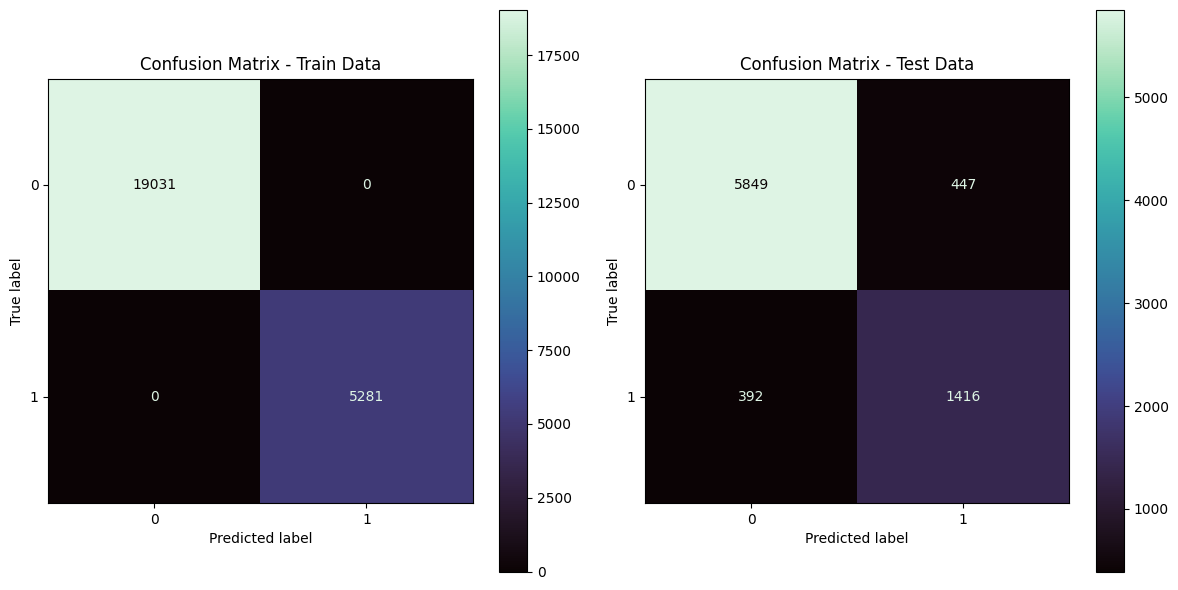

In [70]:
# plot confusion matrix hasil SVM
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

train_cm = ConfusionMatrixDisplay.from_estimator(dtc, X_train, y_train, cmap='mako', ax=ax[0])
train_cm.ax_.set_title('Confusion Matrix - Train Data')

test_cm = ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, cmap='mako', ax=ax[1])
test_cm.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

> Dari hasil `classification report` ini, diperoleh `Recall` dan `Accuracy` yang `overfit`, model cenderung mengingat dari pada memprediksi pola saat training. Dari data training model memprediksi secara sempurna dan dari data test, nilai `FN = 392`. Akan dilakukan hyperparameter tuning kepada model agar nilai `FN` bisa lebih kecil lagi.

#### c. ROC AUC 

In [71]:
# cari nilai AUC Score dari test data 
y_dtc_proba = dtc.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_dtc_proba)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8560941910020128


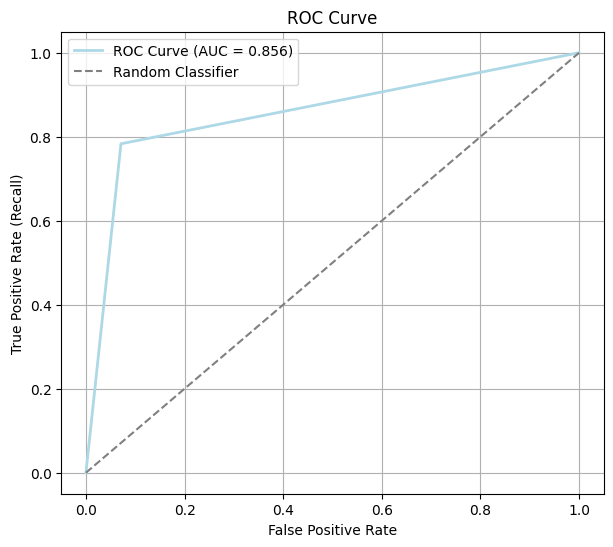

In [72]:
# curva ROC AUC berdasarkan False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_dtc_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='lightblue', label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

> Berdasarkan nilai `AUC Score = 0.856`, model dengan baik mampu memisahkan tiap class dan dari nilai ini, menandakan kita bisa meningkatkan `Recall` tanpa menimbulkan peningkatan `false positive` yang berlebihan. Meskipun dalam projek ini, kita tidak fokus pada false posiive, hanya meningkatkan recall.

#### d. Performance Report

In [73]:
# buat fungsi untuk menyimpan hasil evaluasi kedalam dictionary
def performance_report(reports, y_train, y_pred_train, y_test, y_pred_test, model_name):
    """
    Fungsi ini akan menyimpan hasil recall, score dan FN kedalam dictionary yang kemudian bisa dibuat kedalam dataframe
    Args:
        reports (dict): Dictionary untuk menyimpan hasil evaluasi model
        y_train (array_like): Data train target
        y_pred_train (array_like): Data train setelah prediksi model
        y_test (array_like): Data test target
        y_pred_test (array_like): Data test setelah prediksi model
        model_name (str): Nama model algoritma

    Returns:
        dict: Berupa dictionary berisi hasil evaluasi model 
    """
    # cari recall score
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    # cari accuracy score
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # buat confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    # ambil nilai FN dari confusion matrix
    fn_train = cm_train[1, 0]
    fn_test = cm_test[1, 0]

    reports[model_name] = {
        'Recall Train': recall_train,
        'Recall Test': recall_test,
        'Accuracy Train': accuracy_train,
        'Accuracy Test': accuracy_test,
        'FN Train': fn_train,
        'FN Test': fn_test
    }
    return reports

In [74]:
# Simpan hasil evaluasi model DecisionTree defaul parameter
all_reports = {}
all_reports = performance_report(all_reports, y_train, dtc_pred_train, y_test, dtc_pred_test,'Decision Tree without Tuning')

# Buat kedalam dataframe
pd.DataFrame(all_reports)

,Decision Tree without Tuning
Recall Train,1.000000
Recall Test,0.783186
Accuracy Train,1.000000
Accuracy Test,0.896471
FN Train,0.000000
FN Test,392.000000


> Dari nilai `recall` train dan test, model termasuk `overfitting`. Maka akan dilakukan hyperparameter tuning agar model bisa lebih baik lagi.

### 2. DecisionTree - Hyperparameter Tuned

#### a. Classification Report

In [75]:
# print classification report nya
print('Train\n', classification_report(y_train, dtc_best_train))
print('Test\n', classification_report(y_test, dtc_best_test))

Train
               precision    recall  f1-score   support

           0       0.94      0.85      0.89     19031
           1       0.60      0.80      0.69      5281

    accuracy                           0.84     24312
   macro avg       0.77      0.83      0.79     24312
weighted avg       0.87      0.84      0.85     24312

Test
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      6296
           1       0.62      0.79      0.70      1808

    accuracy                           0.85      8104
   macro avg       0.78      0.83      0.80      8104
weighted avg       0.87      0.85      0.85      8104



#### b. Confusion Matrix

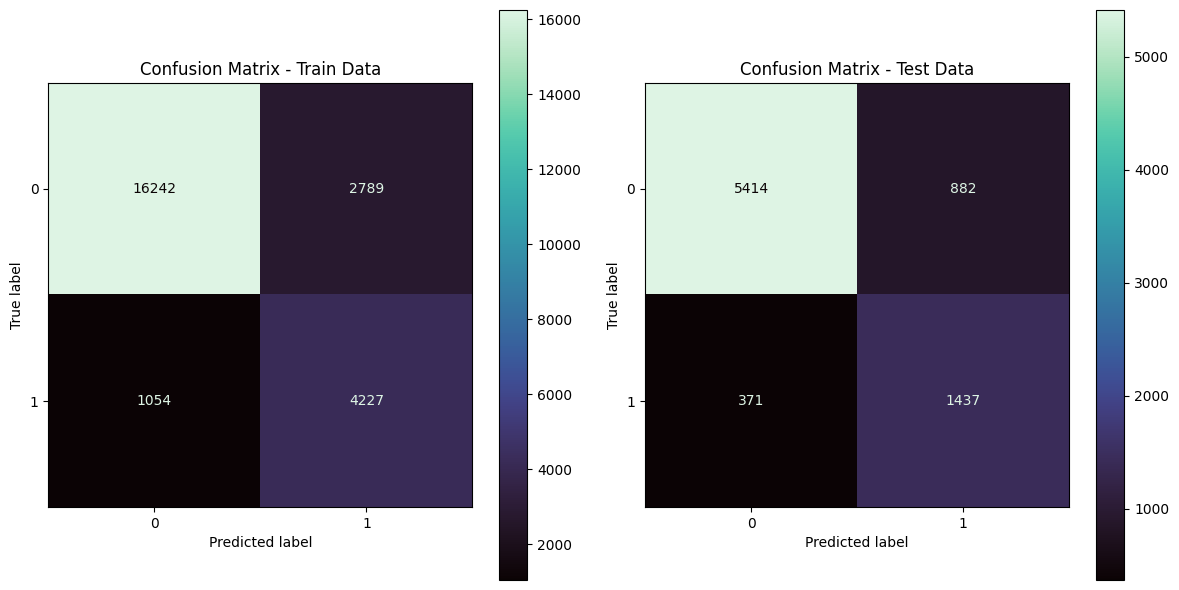

In [76]:
# plot confusion matrix hasil SVM
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

train_cm = ConfusionMatrixDisplay.from_estimator(dtc_best, X_train, y_train, cmap='mako', ax=ax[0])
train_cm.ax_.set_title('Confusion Matrix - Train Data')

test_cm = ConfusionMatrixDisplay.from_estimator(dtc_best, X_test, y_test, cmap='mako', ax=ax[1])
test_cm.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

> Berdasarkan hasil `classification report`, nilai `recall` dan `accuracy` sudah `goodfit`. Nilai `FN = 371` juga sudah turun yang sebelumnya dari `392`.

#### c. ROC AUC

In [77]:
# cari nilai AUC Score dari test data 
y_dtc_best_proba = dtc_best.predict_proba(X_test)[:, 1]

roc_auc_best = roc_auc_score(y_test, y_dtc_best_proba)

print('ROC AUC Score:', roc_auc_best)

ROC AUC Score: 0.9019797476414299


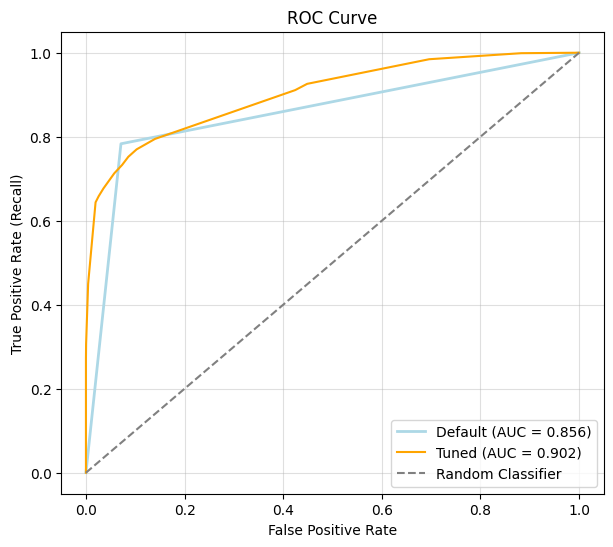

In [78]:
# curva ROC AUC model before dan after tuning
fpr, tpr, _ = roc_curve(y_test, y_dtc_proba)
fpr_best, tpr_best, _ = roc_curve(y_test, y_dtc_best_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='lightblue', label=f'Default (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot(fpr_best, tpr_best, color='orange', label=f'Tuned (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

> Dari hasil tuned, `AUC score = 0.902` menandakan model sangat baik dalam memisahkan kedua class.

#### d. Performance Report

In [79]:
# masukkan hasil metric setelah model tuning
all_reports = performance_report(all_reports, y_train, dtc_best_train, y_test, dtc_best_test,'Decision Tree After Tuning')

# Buat kedalam dataframe
pd.DataFrame(all_reports)

,Decision Tree without Tuning,Decision Tree After Tuning
Recall Train,1.000000,0.800417
Recall Test,0.783186,0.794801
Accuracy Train,1.000000,0.841930
Accuracy Test,0.896471,0.845385
FN Train,0.000000,1054.000000
FN Test,392.000000,371.000000


> Dari hasil tuning, model `Decision Tree` sudah menjadi `goodfit`. Model juga berhasil mengurangi `FN Test` menjadi `371`.

### 3. Evaluate Performance on Dataset

> Evaluasi dataset test menggunakan model `DecisionTree` setelah hyperparameter tuning.

In [80]:
# evaluasi dataset untuk melihat bagaimana hasil dari model dalam memprediksi
evaluate_df = X_test.copy()

# tambah kolom baru
dtc_best_test = dtc_best.predict(X_test)
evaluate_df['actual'] = y_test
evaluate_df['prediction'] = dtc_best_test

# Tambah kolom error_type
def error_type(row):
    """
    Fungsi ini akan menghasilkan FN, FP, TP dan TN berdasarkan value pada kolom 'actual' dan 'prediction'
    Args:
        row (pandas.Series): baris dari dataframe - e.g: pada row(baris) 1, actual 1 prediction 1, maka akan return TP
    Returns:
        str: Hasil apakah FN, FP, TP dan TN
    """
    if row['actual'] == 1 and row['prediction'] == 0:
        return 'FN'
    elif row['actual'] == 0 and row['prediction'] == 1:
        return 'FP'
    elif row['actual'] == 1 and row['prediction'] == 1:
        return 'TP'
    else:
        return 'TN'
# tambahkan kolom error_type beserta value nya berdasarkan kolom actual dan prediction
evaluate_df['error_type'] = evaluate_df.apply(error_type, axis=1)

In [81]:
# cek dataframe saat prediksi selalu FP dan FN
misclassified = evaluate_df[evaluate_df['actual'] != evaluate_df['prediction']]
misclassified

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,actual,prediction,error_type
13741,23,95620,MORTGAGE,7.0,EDUCATION,D,13500,14.960000,0.14,Y,4,0,1,FP
30817,44,65004,MORTGAGE,3.0,EDUCATION,B,25000,11.860000,0.38,N,17,0,1,FP
17523,26,54000,MORTGAGE,10.0,MEDICAL,A,8500,5.420000,0.16,N,3,1,0,FN
26119,27,51600,RENT,2.0,VENTURE,C,13800,13.570000,0.27,Y,6,1,0,FN
19995,35,37400,MORTGAGE,3.0,VENTURE,D,10750,15.950000,0.29,N,5,0,1,FP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23223,27,60000,OWN,0.0,MEDICAL,D,7500,15.370000,0.13,Y,5,0,1,FP
21907,29,50004,MORTGAGE,3.0,DEBTCONSOLIDATION,B,20000,11.580000,0.40,N,7,0,1,FP
12922,26,85000,MORTGAGE,8.0,EDUCATION,D,8500,10.985881,0.10,N,4,0,1,FP
20044,32,50000,RENT,0.0,HOMEIMPROVEMENT,A,3775,6.170000,0.08,N,8,0,1,FP


In [82]:
# lihat summary kolom categorical
misclassified.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,error_type
count,1253,1253,1253,1253,1253
unique,4,6,7,2,2
top,MORTGAGE,EDUCATION,D,N,FP
freq,629,289,367,900,882


> Berdasarkan dari seluruh data test (`X_test`), model gagal memprediksi `1253` data. Model paling sering memprediksi `FP`. Cukup baik untuk model yang dibuat, karena untuk situasi ini, tidak mementingkan jika `FP` tinggi. Hasil ini sesuai dari evaluasi model dengan recall yang tinggi dan precision yang rendah.

> Karena model dikhususkan untuk meningkatkan `Recall`, akan dicoba untuk melihat saat `error_type` hasilnya `FN`.

In [83]:
# Filter saat error_type valuenya FN
fn_df = misclassified[misclassified['error_type'] == 'FN']

# Tampilkan summary nya
fn_df.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,error_type
count,371,371,371,371,371
unique,3,6,3,2,1
top,RENT,MEDICAL,C,N,FN
freq,220,87,169,293,371


> Bisa dilihat dari data deskripsi diatas, bahwa model gagal memprediksi `non_default (0)` `371` kali. Kebanyakan model gagal memprediksi saat tipe ownership `RENT`, tujuan pinjaman `MEDICAL`, `N` history default dan grade loannya `C`.

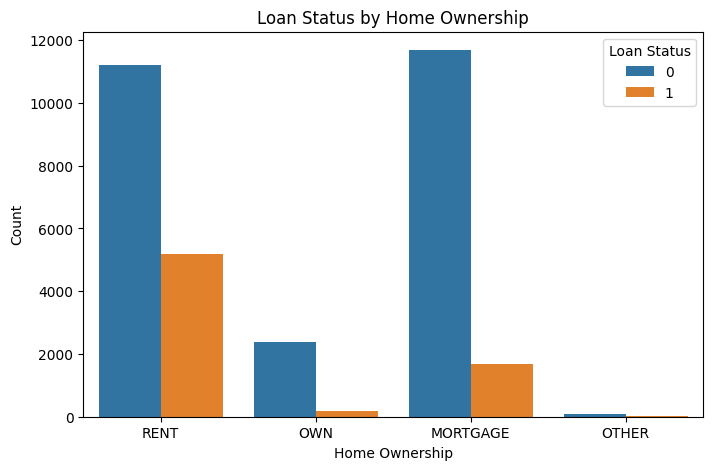

In [84]:
# visualisasi pengaruh person_home_ownership terhadap loan_status
plt.figure(figsize=(8,5))
sns.countplot(x='person_home_ownership', hue='loan_status', data=df)
plt.title('Loan Status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

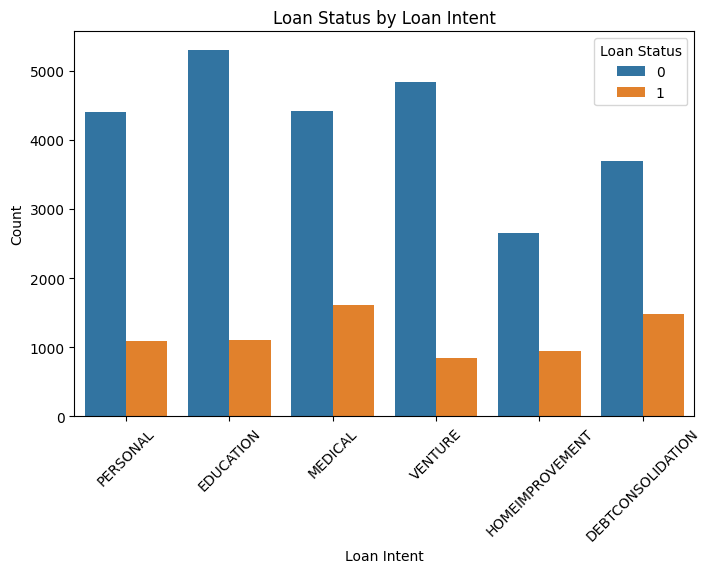

In [85]:
# visualisasi pengaruh loan_intent dengan loan_status
plt.figure(figsize=(8,5))
sns.countplot(x='loan_intent', hue='loan_status', data=df) 
plt.title('Loan Status by Loan Intent')
plt.xlabel('Loan Intent')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

> Dari visualisasi, nilai `RENT` dan `MEDICAL` memang paling tinggi risikonya untuk `default (1)`, sehingga pola ini bisa diamati dan bisa menjadi tolak ukur perhitungan tambahan dalam memberikan approval loan. Sayangnya model juga cukup sering gagal memprediksi saat nilai `RENT` dan `MEDICAL`.

> Namun untuk `loan_grade`, saat dilakukannya EDA pada `loan_grade`, grade `C` cukup rendah risiko nya untuk default, jadi cukup wajar model gagal memprediksi saat grade `C` ternyata hasil **actual** nya `default`. Untuk `cb_person_default_on_file`, dari hasil EDA kurang mempengaruhi `loan_status`, fitur lain cukup signifikan pengaruhnya.

> Faktor dari fitur lain juga bisa mempengaruhi hasil `loan_status`, atau juga dari anomaly.

## x. Model Saving

In [86]:
# model saving pipeline model
with open('dtc_best.pkl', 'wb') as file:
    dill.dump(dtc_best, file)

## xi. Model Inference

## xii. Pengambilan Kesimpulan

> Kesimpulan yang dapat diambil dari seluruh proses modeling terhadap `objektif`:
> - Model yang terbaik dari hasil `Cross Validation` adalah model `DecisionTree`
> - Model `overfitting`, namun setelah hyperparameter tuning, model mempunyai performa baik, dari hasil metric:<br>
> Nilai `recall`: Goodfit, jadi model bisa dengan baik memprediksi `true negative` dan seminimal mungkin untuk prediksi `false negative`. .<br> 
> Nilai `accuracy`: Goodfit, model bisa dengan akurasi yang baik dalam memprediksi.
> Dari `AUC score = 0.902`: Model bisa dengan baik memisahkan antara `default` dan `non-default`.
> - Jadi, model bisa digunakan untuk pihak bank untuk memprediksi, dengan nilai recall yang goodfit, pihak bank bisa mengurangi risiko dimana pengguna sebenarnya default.

> Dari hasil evaluasi diperoleh:<br>
> `Kelebihan` Model:
> - Hasil prediksi error kecil kemungkinnya untuk FN, cukup besar untuk FP, tapi untuk tujuan model, tidak masalah jika FP tinggi.
> - Setelah tuning, dapat mengurangi FN secara signifikan, meski FP naik, namun tidak masalah.

> `Kekurangan` Model:
> - Model secara `false negative` memprediksi status yang memiliki risiko default tinggi seperti pengguna yang `RENT` dan tujuan loan `MEDICAL`. 

> `Further Improvement`:<br>
> Berdasarkan `AUC Score` yang tinggi, masih bisa meningkatkan `recall` lagi tanpa mempengaruhi `precision` meskipun tidak diperhitungkan. Namun belum dapat menemukan parameter yang sesuai dan `RandomSearch` sudah memberikan parameter terbaik. Bisa saja diberikan penalty yang lebih besar meskipun mengurangi accuracy.